In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../astro_codes/')

In [3]:
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits')

In [4]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits')

In [5]:
samples = Table.read('../fits/SF_fits/samples.fits')

In [6]:
import pandas as pd
sparcfire_g_arcs = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [626]:
in_spiral = (samples['all_spiral']) & (samples['in_mass_limit'])
in_sparcfire = sparcfire_g['fit_state'] == 'OK'
in_both = (in_spiral) & (in_sparcfire)
ids = gz_data['dr8objid'][in_both]

# Measure m and w values:
def measure_weighted_average(data,columns):
    p_array = np.array([data[c] for c in columns]).T
    p_array[np.isfinite(p_array) == False] = 0
    p_mean = np.zeros(len(p_array))
    p_sum = np.sum(p_array,axis=1)
    for c in range(len(columns)):
        p_mean += (c+1)*p_array[:,c]
    p_mean = p_mean/p_sum
    p_mean[np.isfinite(p_mean) == False] = 0
    p_absolute = np.argmax(p_array,axis=1) + 1
    return p_mean, p_absolute

m_columns = ['t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh']

w_columns =  ['t10_arms_winding_a28_tight_debiased_rh',
              't10_arms_winding_a29_medium_debiased_rh',
              't10_arms_winding_a30_loose_debiased_rh']

m_wtd_average, m_absolute = measure_weighted_average(gz_data,m_columns)
w_wtd_average, w_absolute = measure_weighted_average(gz_data,w_columns)
gz_statistics = Table(np.array([m_wtd_average,m_absolute,w_wtd_average,w_absolute]).T,
                      names=('m_wtd_avg','m','w_wtd_avg','w'),
                      dtype=(float,int,float,int))

gz_statistics_both = gz_statistics[in_both]

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


In [149]:
import imp
import lookup_arcs
imp.reload(lookup_arcs)
from lookup_arcs import arc_lookup

id_column = np.array(sparcfire_g['name']).astype(np.int64)
chirality_column = np.array(sparcfire_g['chirality_alenWtd'] == 'S-wise').astype(np.int)
chi_array = np.array([id_column,chirality_column]).T

In [152]:
'''
arc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),
                  dtype=(int,int,object,object,object,object,object))
for id_ in ids:
    a = arc_lookup(id_)
    chi = a.chirality(chi_array)
    arc_list = a.arc_list(sparcfire_g_arcs,chi)
    arc_table.add_row(arc_list)
    
arc_table_all = Table(np.zeros((len(gz_data),7)),
                      names=('id','N','P','L','intensity','N_pixels','L_f'),
                      dtype=(int,int,object,object,object,object,object))

arc_table_all[in_both] = arc_table
'''

"\narc_table = Table(names=('id','N','P','L','intensity','N_pixels','L_f'),\n                  dtype=(int,int,object,object,object,object,object))\nfor id_ in ids:\n    a = arc_lookup(id_)\n    chi = a.chirality(chi_array)\n    arc_list = a.arc_list(sparcfire_g_arcs,chi)\n    arc_table.add_row(arc_list)\n    \narc_table_all = Table(np.zeros((len(gz_data),7)),\n                      names=('id','N','P','L','intensity','N_pixels','L_f'),\n                      dtype=(int,int,object,object,object,object,object))\n\narc_table_all[in_both] = arc_table\n"

In [509]:
class ArcStats():
    
    
    def __init__(self,arc_table):
        self.arc_table = arc_table
        self.N_rows = len(arc_table)
        
    def N_greater_than_L(self,px=55):
        N_rows = self.N_rows
        N = np.zeros(N_rows)
        for r in range(N_rows):
            N[r] = (np.array(arc_table['L'][r]) > px).sum()
        return N
    
    def N_greater_than_Lf(self,f=0.5):
        N_rows = self.N_rows
        N = np.zeros(N_rows)
        for r in range(N_rows):
            N[r] = (np.array(arc_table['L_f'][r]) > f).sum()
        return N
    
    def L_total(self,px=55):
        N_rows = self.N_rows
        L = np.zeros(N_rows)
        for r in range(N_rows):
            ok_L = (np.array(arc_table['L'][r]) > px)
            L[r] = (np.array(arc_table['L'][r])[ok_L]).sum()
        return L
    
    def P_average(self,px=55,weighted_average=True,absolute=True):
        N_rows = self.N_rows
        P = np.zeros(N_rows)
        for r in range(N_rows):
            ok_L = np.array(arc_table['L'][r]) > px
            if weighted_average is True:
                weights = np.array(arc_table['L_f'][r])[ok_L]
            else:
                weights = None
            if ok_L.sum() == 0:
                P[r] = 0
            else:
                P[r] = np.average(np.array(arc_table['P'][r])[ok_L],
                                  weights=weights)
        if absolute is True:
            return np.absolute(P)
        else:
            return P
        
    def N_weighted_average(self,px=0):
        N_rows = self.N_rows
        if (type(px) is int) | (type(px) is float):
            px = np.ones(N_rows)*px
        N_wtd_avg = np.zeros(N_rows)
        for r in range(N_rows):
            try:
                ok_L = np.array(arc_table['L'][r]) > px[r]
            except IndexError:
                print("row {} doesn't work?".format(r),px)
            if ok_L.sum() > 0:
                N_wtd_avg[r] = (np.array(arc_table['L_f'][r])).sum()
            else:
                N_wtd_avg[r] = 0
        return N_wtd_avg

In [264]:
arc_stats = ArcStats(arc_table)
L_total = arc_stats.L_total(40)
ok_L = L_total > 0

In [385]:
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*(x) + c

def log(x,m,c,k):
    return m*np.log10(x-k) + c

def measure_rank_correlation(pxs):
    spearman_stats = []
    pearson_stats = []
    N_ok = []
    for px in pxs:
        L_total = arc_stats.L_total(px)
        ok_L = L_total > 0
        rs, _ = spearmanr(L_total[ok_L],gz_statistics_both['m_wtd_avg'][ok_L])
        rp, _ = pearsonr(L_total[ok_L],gz_statistics_both['m_wtd_avg'][ok_L])
        spearman_stats.append(rs)
        pearson_stats.append(rp)
        N_ok.append(ok_L.sum())
    output = Table(np.array([pxs,spearman_stats,pearson_stats,N_ok]).T,
                   names=('px','rs','rp','N'))
    return output
    #return pxs, spearman_stats,pearson_stats,N_ok

rank_stats = measure_rank_correlation(np.linspace(0,100,101))

#plinear, pcov = curve_fit(linear,L_total[ok_L],gz_statistics_both['m_wtd_avg'][ok_L])
#plog, pcov = curve_fit(log,L_total[ok_L],gz_statistics_both['m_wtd_avg'][ok_L])

#x_guide = np.linspace(0,1500,1000)
#_ = plt.plot(x_guide,linear(x_guide,*plinear),color='k')
#_ = plt.plot(x_guide,log(x_guide,*plog),color='r')

In [468]:
from bin_statistics import assign_bins
bins = np.linspace(0.5,15.5,16)
#bins[-1] += 10

x = arc_table['N']
#x = arc_stats.N_greater_than_L(0)
y = gz_statistics_both['m_wtd_avg']

#_ = plt.scatter(x,y,alpha=0.2)

x_bins = np.digitize(x,bins)
L_bests = []
x_plot = []
for bin_ in np.unique(x_bins):
    fracs = []
    in_bin = x_bins == bin_
    binned_x = x[in_bin]
    binned_y = y[in_bin]
    Ls = np.linspace(0,100,51)
    for L in Ls:
        N_arcs_reduced = reduce_arc_table(arc_table[in_bin],L)
        fracs.append((N_arcs_reduced/binned_y).mean())
    fracs_array = np.absolute(np.array(fracs)-1)
    L_best = Ls[np.argmin(fracs_array)]
    L_bests.append(L_best)
    x_plot.append(binned_x.mean())

IndexError: invalid index to scalar variable.

In [397]:
def reduce_arc_table(arc_table,L=0,return_mask=False):
    N_rows = len(arc_table)
    if type(L) is int:
        L = np.ones(N_rows)*L
    if return_mask is True:
        N_arcs_reduced = []
    else:
        N_arcs_reduced = np.zeros(N_rows)
    
    for r in range(N_rows):
        arc_mask = np.array(arc_table['L'][r]) > L[r]
        if return_mask is True:
            N_arcs_reduced.append(arc_mask)
        else:
            N_arcs_reduced[r] = arc_mask.sum()
    return N_arcs_reduced

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


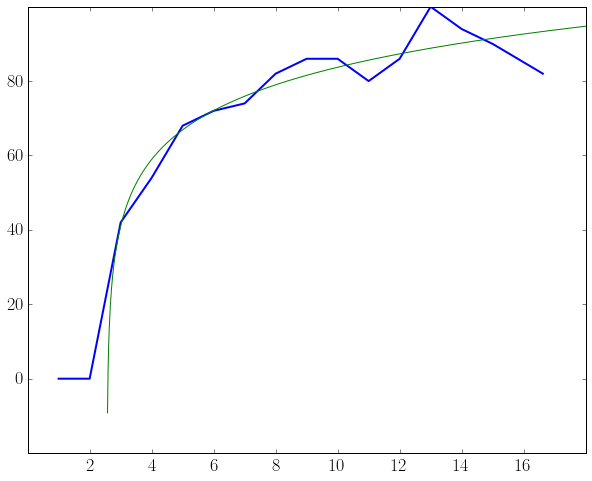

In [388]:
x_plot = np.array(x_plot)
L_bests = np.array(L_bests)

_ = plt.plot(x_plot,L_bests,linewidth=2)

ok_xy = (x_plot > 0) & (L_bests > 0)

plog, pcov = curve_fit(log,x_plot[ok_xy],L_bests[ok_xy])

x_guide = np.linspace(0,18,1000)
_ = plt.plot(x_guide,log(x_guide,*plog))

In [393]:
variable_Lmin = log(x,*plog)
variable_Lmin[np.isfinite(variable_Lmin) == False] = 0

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


In [404]:
N = reduce_arc_table(arc_table,variable_Lmin,return_mask=False)

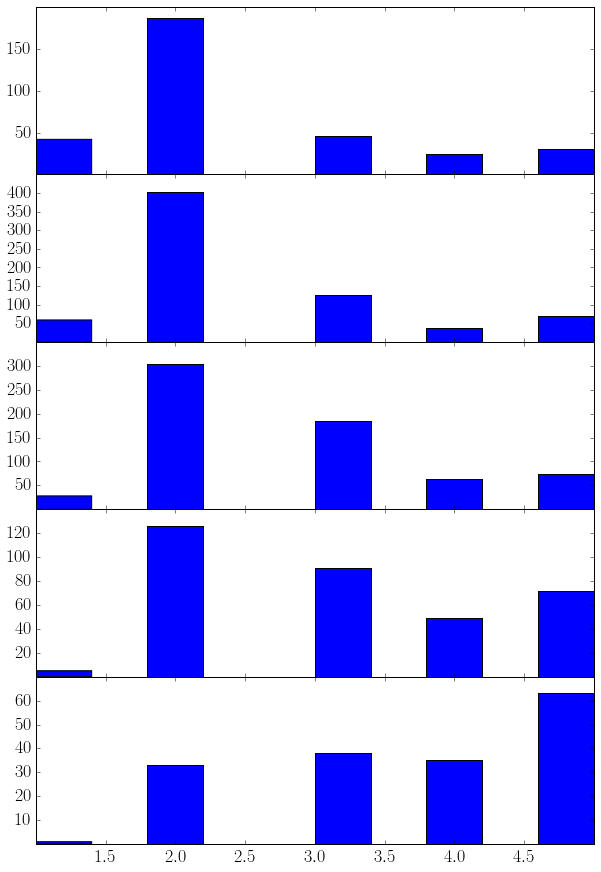

In [510]:
# Now do the same using the 'weighted average' arm numbers:
N_wtd_avg = ArcStats(arc_table).N_weighted_average()

x = N_wtd_avg
y = gz_statistics_both['m']

bins = np.linspace(1,5,26)
bins[-1] += 10
x_bins = np.digitize(N_wtd_avg,bins=bins)

L_bests = []
x_plot = []
for bin_ in np.unique(x_bins):
    fracs = []
    in_bin = x_bins == bin_
    binned_x = x[in_bin]
    binned_y = y[in_bin]
    Ls = np.linspace(0,200,21)
    for L in Ls:
        N_arcs_reduced = ArcStats(arc_table[in_bin]).N_weighted_average(L)
        fracs.append((N_arcs_reduced/binned_y).mean())
    fracs_array = np.absolute(np.array(fracs)-1)
    L_best = Ls[np.argmin(fracs_array)]
    L_bests.append(L_best)
    x_plot.append(binned_x.mean())

row 0 doesn't work? 0.0


UnboundLocalError: local variable 'ok_L' referenced before assignment

In [561]:
class ArcStats():
    
    
    def __init__(self,arc_table):
        self.arc_table = arc_table
        self.N_rows = len(arc_table)
        self.setup_array = np.zeros(self.N_rows)
        
    def value_to_array(self,value=0,variable_name='i'):
        N_rows = self.N_rows
        if (isinstance(value,int)) or (isinstance(value,float)):
            return np.full(N_rows,value)
        else:
            if len(value) != N_rows:
                raise ValueError('Length of variable {} does not'
                                 'match number of rows'.format(variable_name))
            else:
                return value
        
    def N_arcs_L(self,px=55):
        px_array = self.value_to_array(px)
        N = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            N[r] = (L_r > px_array[r]).sum()
        return N
    
    def N_arcs_Lf(self,f=0.5):
        f_array = self.value_to_array(f)
        N = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L_f'][r])
            N[r] = (L_r > f_array[r]).sum()
        return N
    
    def L_total(self,px=55):
        px_array = self.value_to_array(px)
        L = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            ok_L = L_r > px_array[r]
            L[r] = L_r[ok_L].sum()
        return L
    
    def P_average(self,px=55,weighted_average=True,absolute=True):
        px_array = self.value_to_array(px)
        P = self.setup_array
        for r in range(self.N_rows):
            L_r = np.array(arc_table['L'][r])
            P_r = np.array(arc_table['P'][r])
            ok_L = L_r > px_array[r]
            if weighted_average is True:
                weights = np.array(arc_table['L_f'][r])[ok_L]
            else:
                weights = None
            if ok_L.sum() == 0:
                P[r] = 0
            else:
                P[r] = np.average(P_r[ok_L],weights=weights)
        if absolute is True:
            return np.absolute(P)
        else:
            return P
        
    def N_weighted_average(self,px=0):
        px_array = self.value_to_array(px)
        N_wtd_avg = self.setup_array
        N_rows = self.N_rows
        for r in range(N_rows):
            L_r = np.array(arc_table['L'][r])
            Lf_r = np.array(arc_table['L_f'][r])
            ok_L = L_r > px_array[r]
            if ok_L.sum() > 0:
                N_wtd_avg[r] = (Lf_r[ok_L]).sum()
            else:
                N_wtd_avg[r] = 0
        return N_wtd_avg
    
a = ArcStats(arc_table)

In [553]:
N_wtd_avg = a.N_weighted_average(0)

x = N_wtd_avg
y = gz_statistics_both['m']

bins = np.linspace(1,5,26)
bins[-1] += 10
x_bins = np.digitize(N_wtd_avg,bins=bins)

L_bests = []
x_plot = []
for bin_ in np.unique(x_bins):
    fracs = []
    in_bin = x_bins == bin_
    binned_x = x[in_bin]
    binned_y = y[in_bin]
    Ls = np.linspace(0,200,21)
    for L in Ls:
        N_arcs_reduced = ArcStats(arc_table[in_bin]).N_weighted_average(L)
        fracs.append((N_arcs_reduced/binned_y).mean())
    fracs_array = np.absolute(np.array(fracs)-1)
    L_best = Ls[np.argmin(fracs_array)]
    L_bests.append(L_best)
    x_plot.append(binned_x.mean())

[ -15.76034545  100.44711775]


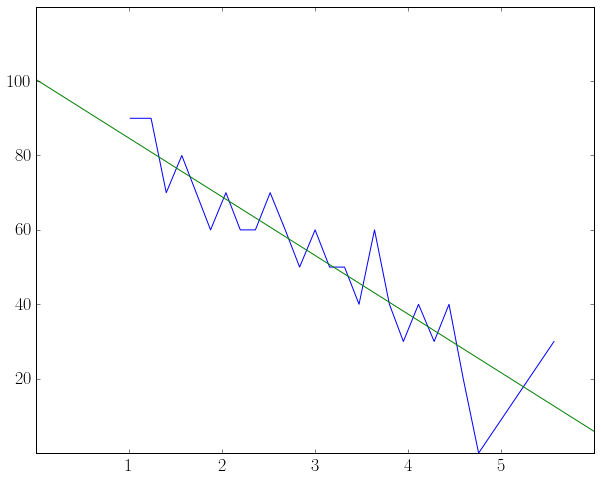

In [579]:
_ = plt.plot(x_plot,L_bests)
plinear, pcov = curve_fit(linear,x_plot,L_bests)
print(plinear)
variable_L = linear(N_wtd_avg,*plinear)

N_ = a.N_weighted_average(variable_L)
x_guide = np.linspace(0,6,100)
_ = plt.plot(x_guide,linear(x_guide,*plinear))

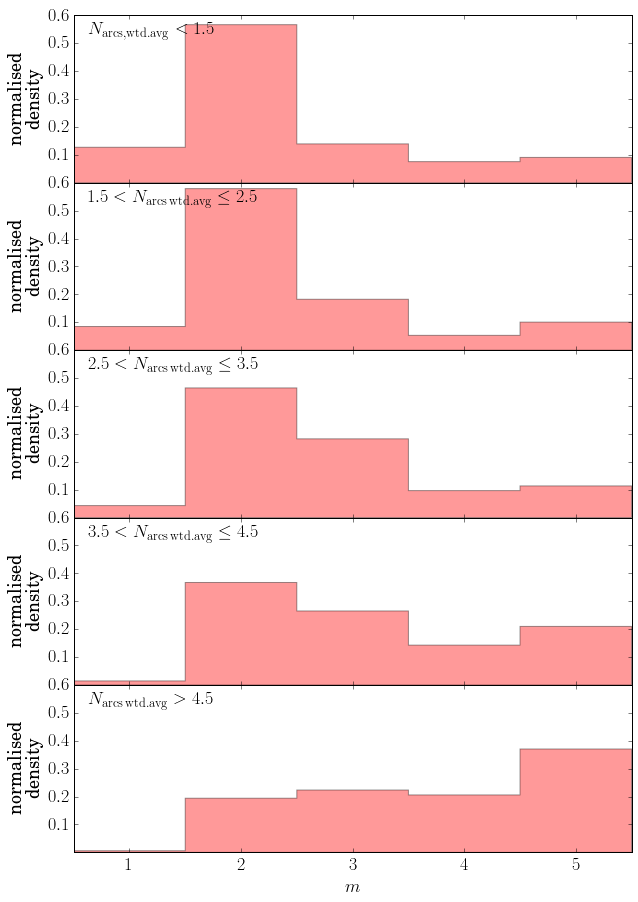

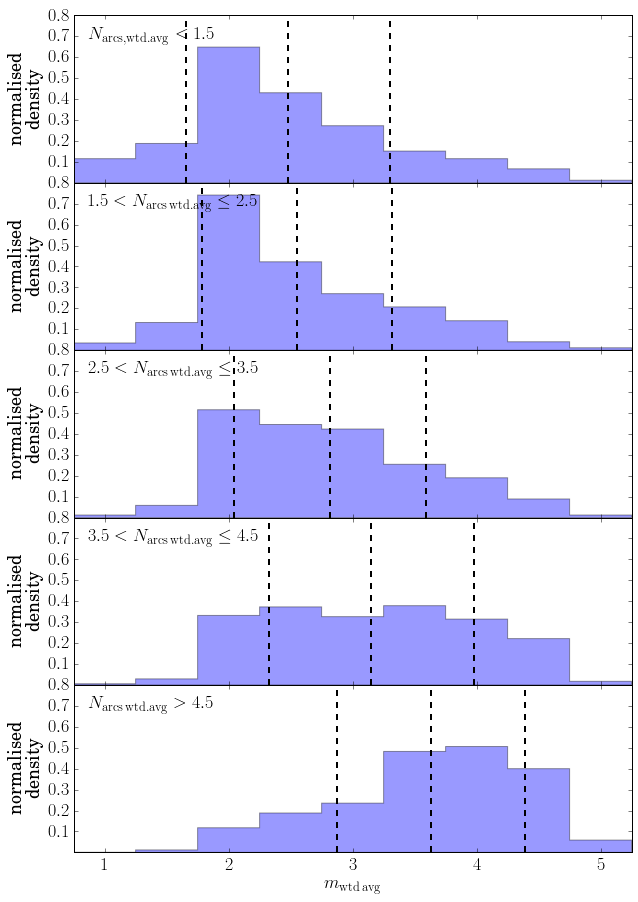

In [617]:
def arm_number_stack(x,bins,value='m',plot_means=True,**kwargs):
    x_bins = np.digitize(x,bins)
    unique_bins = np.unique(x_bins)
    unique_bins = unique_bins[1:] if 0 in unique_bins else unique_bins
    n_bins = len(unique_bins)
    fig, axarr = plt.subplots(n_bins,1,figsize=(10,3*n_bins),
                              sharex=True,sharey=True)
    fig.subplots_adjust(hspace=0)
    if value is 'm':
        histogram_bins = np.linspace(0.5,5.5,6)
        axarr[-1].set_xlabel('$m$')
    else:
        histogram_bins = np.linspace(0.75,5.25,10)
        axarr[-1].set_xlabel('$m_\mathrm{wtd \, avg}$')
    axarr[-1].set_xlim(histogram_bins[0],histogram_bins[-1])    
    
    for b, bin_ in enumerate(unique_bins):
        in_bin = x_bins == bin_
        h = gz_statistics_both[value][in_bin]
        plt.sca(axarr[b])
        axarr[b].hist(h,bins=histogram_bins,**kwargs)
        axarr[b].set_ylabel('normalised \n density')
        if plot_means is True:
            for line in (np.mean(h),np.mean(h)-np.std(h),np.mean(h)+np.std(h)):
                plt.axvline(line,color='k',linewidth=2,
                                  linestyle='dashed')
        
    return fig, axarr
        
#_ = plt.scatter(N,gz_statistics_both['m_wtd_avg'],alpha=0.2)
bins = np.linspace(0.5,5.5,6)
bins[-1] += 10
fig, axarr = arm_number_stack(N_,bins,histtype='stepfilled',alpha=0.4,color='r',normed=True,
                              plot_means=False)

labels = ['$N_\mathrm{{arcs, wtd. avg}} < 1.5$',
          '$1.5 < N_\mathrm{{arcs\,  wtd. avg}} \leq 2.5$',
          '$2.5 < N_\mathrm{{arcs \, wtd. avg}} \leq 3.5$',
          '$3.5 < N_\mathrm{{arcs \, wtd. avg}} \leq 4.5$',
          '$N_\mathrm{{arcs \, wtd. avg}} > 4.5$']

for a, ax in enumerate(axarr):
    ax.text(0.025,0.95,labels[a],
            ha='left',va='top',transform=ax.transAxes)

fig, axarr = arm_number_stack(N_,bins,histtype='stepfilled',alpha=0.4,color='b',normed=True,
                              value='m_wtd_avg')

for a, ax in enumerate(axarr):
    ax.text(0.025,0.925,labels[a],
            ha='left',va='top',transform=ax.transAxes)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2269 but corresponding boolean dimension is 2188


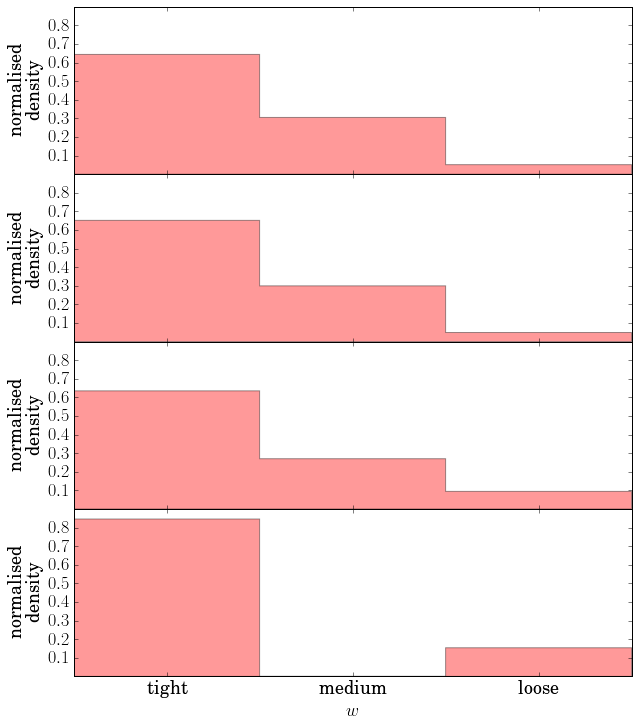

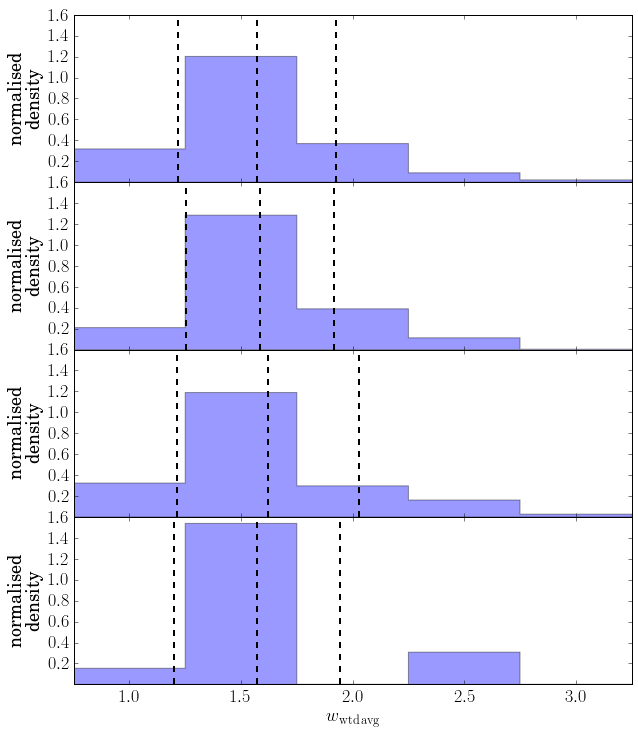

In [664]:
# ok, from our new method, what do the pitch angles look like?
from xy_plots import x_vs_y

x = ArcStats(arc_table).P_average(variable_L)
y = gz_statistics_both['w_wtd_avg']
ok_P = P > 0
P = ArcStats(arc_table).P_average(variable_L)

xy = x_vs_y(x[ok_P],y[ok_P])
fig = plt.figure(figsize=(10,10))
#ax = plt.subplot(111)

_ = xy.continuous_vs_continuous_binned(ax,bins=12,equal_N=False,
                                       color='b',linewidth=2,marker='o',capthick=2)

def winding_stack(x,bins,value='w',plot_means=True,**kwargs):
    x_bins = np.digitize(x,bins)
    unique_bins = np.unique(x_bins)
    unique_bins = unique_bins[1:] if 0 in unique_bins else unique_bins
    n_bins = len(unique_bins)
    fig, axarr = plt.subplots(n_bins,1,figsize=(10,3*n_bins),
                              sharex=True,sharey=True)
    fig.subplots_adjust(hspace=0)
    if value is 'w':
        histogram_bins = np.linspace(0.5,3.5,4)
        axarr[-1].set_xlabel('$w$')
        axarr[-1].set_xticks([1,2,3])
        axarr[-1].set_xticklabels(['tight','medium','loose'])
    else:
        histogram_bins = np.linspace(0.75,3.25,6)
        axarr[-1].set_xlabel('$w_\mathrm{wtd \, avg}$')
        
    axarr[-1].set_xlim(histogram_bins[0],histogram_bins[-1])    
    
    for b, bin_ in enumerate(unique_bins):
        in_bin = x_bins == bin_
        h = gz_statistics_both[value][in_bin]
        plt.sca(axarr[b])
        axarr[b].hist(h,bins=histogram_bins,**kwargs)
        axarr[b].set_ylabel('normalised \n density')
        if plot_means is True:
            for line in (np.mean(h),np.mean(h)-np.std(h),np.mean(h)+np.std(h)):
                plt.axvline(line,color='k',linewidth=2,
                                  linestyle='dashed')
    plt.sca(axarr[-1])

    return fig, axarr

bins = np.linspace(10,40,4)
fig, axarr = winding_stack(P[ok_P],bins,histtype='stepfilled',alpha=0.4,color='r',normed=True,
                           plot_means=False)

fig, axarr = winding_stack(P[ok_P],bins,histtype='stepfilled',alpha=0.4,color='b',normed=True,
                           value='w_wtd_avg')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


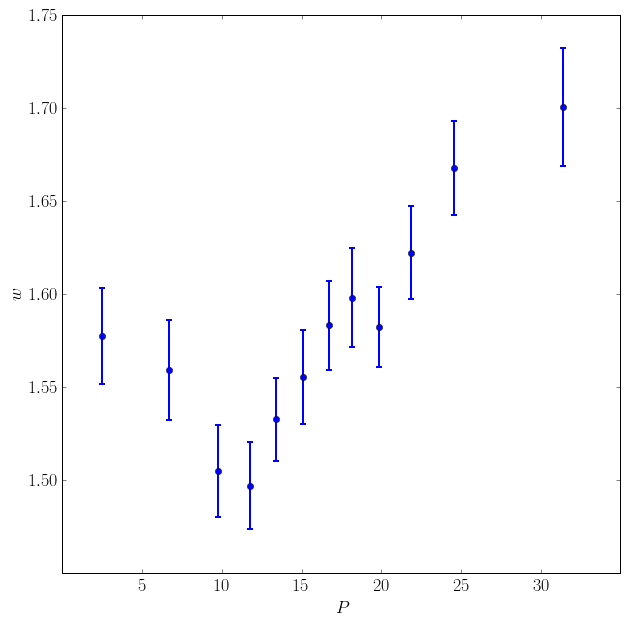

In [675]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
_ = xy.continuous_vs_continuous_binned(ax,bins=12,equal_N=True,
                                       color='b',linewidth=2,fmt='o',capthick=2)

plt.xlabel('$P$')
plt.ylabel('$w$')